In [82]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

In [83]:
import pandas as pd
import numpy as np

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#Returns whether TensorFlow was built with CUDA (GPU) support.
tf.test.is_gpu_available()
tf.test.is_built_with_cuda()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 754276659266902570
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4080954277011013994
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5245679242874279970
physical_device_desc: "device: XLA_GPU device"
]


True

In [84]:
df_merged_pca = pd.read_csv(r'pca_weakly_2018.zip', compression='zip')
df_merged_pca = df_merged_pca.set_index('Datetime')

In [86]:
df_merged_pca.describe()

,gic,principal component 1,principal component 2,principal component 3
count,525600.000000,5.256000e+05,5.256000e+05,5.256000e+05
mean,0.003133,-5.763179e-13,9.230610e-13,2.068166e-14
std,0.184809,4.251697e+03,1.688399e+03,3.682194e+02
min,-9.220000,-4.104130e+03,-1.459002e+04,-1.377263e+03
25%,-0.080000,-3.342211e+03,-6.153512e+02,-1.916370e+02
50%,0.010000,-1.136530e+03,-2.404744e+02,-6.564193e+01
75%,0.090000,1.911043e+03,1.583189e+02,7.795040e+01
max,4.700000,3.082539e+04,1.611816e+04,4.927620e+03


In [87]:
df_merged_original = pd.read_csv(r'master_weakly_2018.zip', compression='zip')
df_merged_original['Datetime'] = df_merged_original['Unnamed: 0']
df_merged_original = df_merged_original.drop(['Unnamed: 0'], axis=1)
df_merged_original = df_merged_original.set_index('Datetime')

In [88]:
df_merged_original = df_merged_original.replace([99999.9, 9999.99, 999.99, 999999.0 ,999999.00,-99999.990000,-99999.990000, '#REF!',np.nan ], 0)

In [91]:
df_merged_original.describe()

,gic,Bz,By,Bx,clock,AE,SymH,Vsw,Dsw,Psw,...,GSM_By,GSM_Bz,GSE_Vx,GSE_Vy,GSM_Vz,CLOCK_ANGLE_GSM,DENSITY,PDYN,EPSILON,NEWELL
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,...,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.00000,525600.000000
mean,0.003133,-0.098035,-0.405388,0.151692,3.076170,17.234646,-6.446583,374.198593,6.302422,1.942079,...,-0.399487,-0.094821,314.891988,-0.421297,-2.097201,175.447564,5.369589,1.653922,60.66616,2336.427986
std,0.184809,2.332359,2.944742,2.895380,1.888315,63.196621,12.762283,141.655918,4.887514,1.303693,...,3.012913,2.406987,188.436645,16.216568,15.014644,108.628338,5.132704,1.416516,155.18221,2943.020818
min,-9.220000,-20.159200,-17.249200,-15.024000,0.000000,0.000000,-204.240000,0.000000,0.000000,0.000000,...,-17.720000,-20.940000,0.000000,-149.380000,-105.050000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-0.080000,-1.313600,-2.306800,-1.930000,1.431038,0.000000,-12.000000,336.148000,3.251600,1.211200,...,-2.350000,-1.350000,298.700000,-5.820000,-8.960000,80.700000,2.000000,0.800000,0.00000,0.600000
50%,0.010000,0.000000,-0.133267,0.000000,3.296199,0.000000,-4.520000,382.310500,5.281667,1.724800,...,-0.120000,0.000000,364.700000,0.000000,0.000000,186.900000,4.500000,1.500000,12.70000,1293.700000
75%,0.090000,1.190000,1.484800,2.272400,4.730171,0.000000,1.000000,448.644000,8.352400,2.479200,...,1.520000,1.220000,430.800000,7.300000,3.580000,270.800000,7.600000,2.300000,60.10000,3613.600000
max,4.700000,15.259600,18.298400,13.947200,6.283185,1499.280000,43.160000,717.420000,64.755767,17.449833,...,18.960000,16.070000,723.000000,125.480000,152.310000,359.900000,68.200000,18.900000,3772.10000,24949.500000


In [22]:
df_merged_pca

,gic,principal component 1,principal component 2,principal component 3
Datetime,,,,
2018-01-01 00:00:00,-5.5407,2522.722352,4980.099206,40.021187
2018-01-01 00:01:00,-5.0996,6791.115197,-1006.520481,-115.982313
2018-01-01 00:02:00,-4.6552,6506.883006,-1160.397033,-101.734742
2018-01-01 00:03:00,-4.5236,6644.695906,-1427.581950,-119.780090
2018-01-01 00:04:00,-4.4976,6574.535937,-1321.890212,-131.641522
...,...,...,...,...
2018-12-31 23:55:00,3.3244,-3719.834045,-364.708532,-24.776885
2018-12-31 23:56:00,3.2607,-3904.253743,-82.410442,-24.772698
2018-12-31 23:57:00,3.1755,-3864.619447,-52.205333,12.987469


In [92]:
# config values
embed_size = 1 # how big is each word vector
max_features = 3 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 4 # max number of words in a question to use

In [93]:
import matplotlib.pyplot as plt

plt.close('all')

In [94]:
# df = pd.read_csv(r'C:\Users\cgree\Documents\Astra\Space_weather5_22\weakley_all\example_data_in_order.csv')

In [95]:
df1,df2,df3,df4,df5 = np.array_split(df_merged_pca, 5)

In [96]:
df1.columns

Index(['gic', 'principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')

In [97]:
df1.columns

Index(['gic', 'principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')

In [98]:
df1.head()

,gic,principal component 1,principal component 2,principal component 3
Datetime,,,,
2018-01-01 00:00:00,0.17,2522.722352,4980.099206,40.021187
2018-01-01 00:01:00,0.17,6791.115197,-1006.520481,-115.982313
2018-01-01 00:02:00,0.22,6506.883006,-1160.397033,-101.734742
2018-01-01 00:03:00,0.13,6644.695906,-1427.581950,-119.780090
2018-01-01 00:04:00,0.09,6574.535937,-1321.890212,-131.641522


In [99]:
df1.describe()

,gic,principal component 1,principal component 2,principal component 3
count,105120.000000,105120.000000,105120.000000,105120.000000
mean,0.000481,-108.854859,100.002083,-51.189752
std,0.148808,3912.923803,1491.786335,318.134784
min,-3.480000,-4103.352655,-9481.828420,-1205.716364
25%,-0.070000,-3336.781861,-558.646199,-222.094468
50%,0.010000,-1036.435610,-239.424960,-86.634101
75%,0.080000,1864.188823,217.032550,29.951965
max,2.170000,21830.066236,12021.381620,3218.444928


# Normalize data

In [145]:
import pandas as pd
from sklearn import preprocessing

x = df1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Scale

In [146]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [147]:
scaler = MinMaxScaler()

In [148]:
df1.columns

Index(['gic', 'principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')

In [149]:
df1[['gic', 'principal component 1', 'principal component 2',
       'principal component 3']] = scaler.fit_transform(df1[['gic', 'principal component 1', 'principal component 2',
       'principal component 3']])

# Rolling Mean

In [150]:
df1

,gic,principal component 1,principal component 2,principal component 3
Datetime,,,,
2018-01-01 00:00:00,0.646018,0.255503,0.672547,0.281576
2018-01-01 00:01:00,0.646018,0.420094,0.394142,0.246314
2018-01-01 00:02:00,0.654867,0.409134,0.386986,0.249535
2018-01-01 00:03:00,0.638938,0.414448,0.374560,0.245456
2018-01-01 00:04:00,0.631858,0.411742,0.379475,0.242775
...,...,...,...,...
2018-03-14 23:55:00,0.612389,0.610906,0.344341,0.177561
2018-03-14 23:56:00,0.612389,0.641368,0.340759,0.172825
2018-03-14 23:57:00,0.633628,0.640827,0.380391,0.174415


In [151]:
# df1r = df1.rolling(160).mean()

In [152]:
# df1r = df1r.dropna()

In [153]:
# df1r

F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Datetime'>

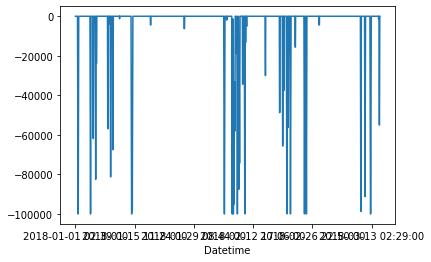

In [41]:
df1.gic.plot()

F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Datetime'>

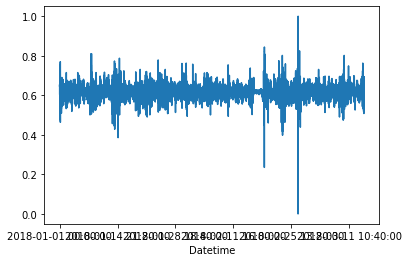

In [154]:
df1.gic.plot()

F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Datetime'>

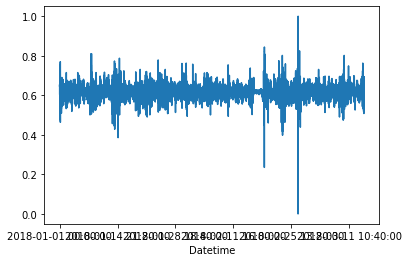

In [155]:
df1.gic.plot()

F:\Astra\conda2\envs\Austin\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Datetime'>

<Figure size 432x288 with 0 Axes>

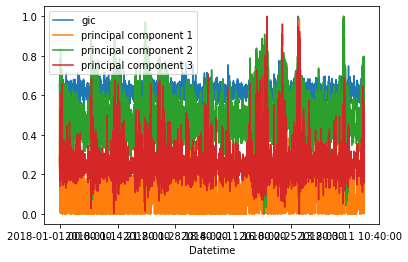

In [156]:
plt.figure()

df1.plot()

In [157]:
#df2.plot.bar()

<AxesSubplot:ylabel='Frequency'>

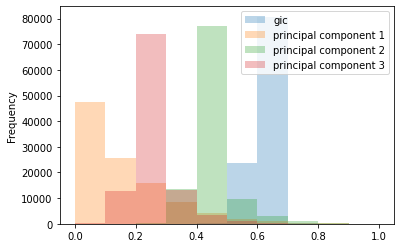

In [158]:
df1.plot.hist(alpha=0.3)

<AxesSubplot:ylabel='Frequency'>

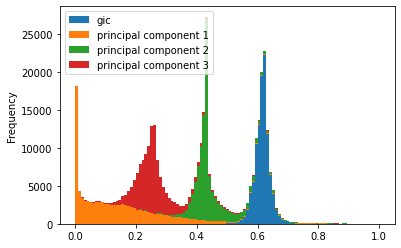

In [159]:
df1.plot.hist(stacked=True, bins=105)

In [160]:
df1.groupby('gic').count()

,principal component 1,principal component 2,principal component 3
gic,,,
0.000000,1,1,1
0.026549,1,1,1
0.051327,1,1,1
0.072566,1,1,1
0.095575,1,1,1
...,...,...,...
0.980531,1,1,1
0.982301,1,1,1
0.985841,1,1,1


In [161]:
pd.set_option("max_rows", 418)

In [162]:
df1['gic'].value_counts()

0.617699    4618
0.615929    4348
0.623009    4187
0.614159    4142
0.621239    4093
0.619469    3692
0.626549    3516
0.628319    3505
0.608850    3342
0.610619    3337
0.624779    3307
0.612389    3021
0.631858    2687
0.630088    2665
0.603540    2650
0.633628    2574
0.605310    2544
0.607080    2444
0.600000    2161
0.598230    2091
0.637168    2061
0.601770    2011
0.635398    1924
0.594690    1760
0.640708    1626
0.596460    1577
0.591150    1542
0.592920    1437
0.638938    1410
0.589381    1335
0.642478    1289
0.585841    1193
0.587611    1082
0.646018    1052
0.644248    1012
0.584071     983
0.647788     923
0.580531     921
0.582301     864
0.578761     796
0.651327     776
0.575221     687
0.649558     685
0.653097     622
0.576991     605
0.573451     556
0.656637     509
0.654867     480
0.569912     476
0.571681     442
0.658407     401
0.566372     390
0.568142     388
0.660177     343
0.661947     336
0.663717     300
0.564602     299
0.665487     264
0.562832     2

In [163]:
# df['gic'].value_counts(normalize=True)

In [164]:
df

,0,1,2,3
0,0.646018,0.255503,0.672547,0.281576
1,0.646018,0.420094,0.394142,0.246314
2,0.654867,0.409134,0.386986,0.249535
3,0.638938,0.414448,0.374560,0.245456
4,0.631858,0.411742,0.379475,0.242775
...,...,...,...,...
105115,0.612389,0.610906,0.344341,0.177561
105116,0.612389,0.641368,0.340759,0.172825
105117,0.633628,0.640827,0.380391,0.174415
105118,0.651327,0.387029,0.797935,0.225970


In [165]:
#data cleaning
df = df.fillna(0)
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [166]:
df

,0,1,2,3
0,0.646018,0.255503,0.672547,0.281576
1,0.646018,0.420094,0.394142,0.246314
2,0.654867,0.409134,0.386986,0.249535
3,0.638938,0.414448,0.374560,0.245456
4,0.631858,0.411742,0.379475,0.242775
...,...,...,...,...
105115,0.612389,0.610906,0.344341,0.177561
105116,0.612389,0.641368,0.340759,0.172825
105117,0.633628,0.640827,0.380391,0.174415
105118,0.651327,0.387029,0.797935,0.225970


In [167]:
df.summary()

AttributeError: 'DataFrame' object has no attribute 'summary'

In [168]:
df1.columns

Index(['gic', 'principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')

In [169]:
#data prep
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [170]:
#separating gic
y = df1['gic']
X = df1[['principal component 1', 'principal component 2',
       'principal component 3']]

In [171]:
# The input data: dividing into train (75%) and validation data (25%)

x_train_len = round(X.shape[0]*0.75)
x_train = X[:x_train_len]
x_validation = X[x_train_len:]
y_train = y[:x_train_len]
y_validation = y[x_train_len:]

# print Test and Validation data lenght
print("Train data points: ", x_train_len)
print("Validation data points: ", x_validation.shape[0])

Train data points:  78840
Validation data points:  26280


In [172]:
X

,principal component 1,principal component 2,principal component 3
Datetime,,,
2018-01-01 00:00:00,0.255503,0.672547,0.281576
2018-01-01 00:01:00,0.420094,0.394142,0.246314
2018-01-01 00:02:00,0.409134,0.386986,0.249535
2018-01-01 00:03:00,0.414448,0.374560,0.245456
2018-01-01 00:04:00,0.411742,0.379475,0.242775
...,...,...,...
2018-03-14 23:55:00,0.610906,0.344341,0.177561
2018-03-14 23:56:00,0.641368,0.340759,0.172825
2018-03-14 23:57:00,0.640827,0.380391,0.174415


In [173]:
y_validation = y_validation.reset_index(drop=True)

In [174]:
y_validation

0        0.615929
1        0.601770
2        0.615929
3        0.619469
4        0.585841
           ...   
26275    0.612389
26276    0.612389
26277    0.633628
26278    0.651327
26279    0.693805
Name: gic, Length: 26280, dtype: float64

# Building code for PCA and eigenvalues

### ---------------------------

In [175]:
# with gzip.open('X:\data_dumps\Bullrun_gic_qdc_mean_dres10_tres300.csv.gz') as f:
#     df2 = pd.read_csv(f)

In [176]:
# df2 = df2.replace(to_replace= r'/', value= ' ', regex=True)
# df2

In [177]:
# df3 = pd.read_csv(r'C:\Users\cgree\Documents\Astra\Space_weather5_22\2018_sm_reg.csv')
# df3 = df3.set_index('Date_UTC')
# df3

In [178]:
# import pandas as pd

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# clean_dataset(df_merged)

# ----------------

### ------------------------------

In [179]:
#data prep
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [180]:
# The input data: dividing into train (75%) and validation data (25%)

x_train_len = round(X.shape[0]*0.75)
x_train = X[:x_train_len]
x_validation = X[x_train_len:]
y_train = y[:x_train_len]
y_validation = y[x_train_len:]

# print Test and Validation data lenght
print("Train data points: ", x_train_len)
print("Validation data points: ", x_validation.shape[0])

Train data points:  78840
Validation data points:  26280


In [136]:
import matplotlib.pyplot as plt
import pandas as pd

In [140]:
# A class that will define all the regression models as methods

class Models(object):
    
    global seed 
    seed = 34234
    
    # Initialization 
    def __init__(self, x_train, x_validation, y_train, y_validation):
        # changing input as dataframe to list
        self.x_train = [x_train.iloc[i].tolist() for i in range(len(x_train))]
        self.x_validation = [x_validation.iloc[i].tolist() for i in range(len(x_validation))]
        self.y_train = y_train.tolist()
        self.y_validation = y_validation.tolist()
    
    
    @staticmethod
    def print_info(cross_val_scores, mse, accuracy):
        print("Cross Validation Scores: ", cross_val_scores)
        print("Mean Squared Error: ", mse)
        print("accuracy: ", accuracy)
        
        
    # Linear Regression 
    def linear_regression(self, x_train, x_validation,  y_train, y_validation):
        reg = linear_model.LinearRegression()
        # X = np.array(X).reshape([-1, 1])
        reg.fit(self.x_train, self.y_train)
        y_pred_list = reg.predict(self.x_validation)
        plt.plot(y_pred_list)
        plt.plot(y_validation)
        plt.ylabel('GIC')
        plt.show()
        mse = mean_squared_error(self.y_validation, y_pred_list)
        accuracy = reg.score(self.x_validation,self.y_validation)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(reg, self.x_train, self.y_train, cv=kfold)
        print("\nLinear Regression Model")
        self.print_info(cross_val_scores, mse, accuracy)
        return cross_val_scores, mse, accuracy
        
    # Random Forest Regression model 
    def random_forest(self, x_train, x_validation,  y_train, y_validation):
        rfr = RandomForestRegressor(n_estimators=8, max_depth=8, random_state=12, verbose=0)
        # X = np.array(X).reshape([-1, 1])
        rfr.fit(self.x_train, self.y_train)
        y_pred_list = rfr.predict(self.x_validation)
        plt.plot(y_pred_list)
        plt.plot(y_validation)
        plt.ylabel('GIC')
        plt.show()
        mse = mean_squared_error(self.y_validation, y_pred_list)
        accuracy = rfr.score(self.x_validation,self.y_validation)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(rfr, self.x_train, self.y_train, cv=kfold)
        print("\nRandom Forest Regressor")
        self.print_info(cross_val_scores, mse, accuracy)
        return cross_val_scores, mse, accuracy
            
    # Lasso method 
    def lasso(self, x_train, x_validation,  y_train, y_validation):
        reg = linear_model.Lasso(alpha = 0.1)
        # X = np.array(X).reshape([-1, 1])
        reg.fit(self.x_train, self.y_train)
        y_pred_list = reg.predict(self.x_validation)
        plt.plot(y_pred_list)
        plt.plot(y_validation)
        plt.ylabel('GIC')
        plt.show()
        mse = mean_squared_error(self.y_validation, y_pred_list)
        accuracy = reg.score(self.x_validation,self.y_validation)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(reg, self.x_train, self.y_train, cv=kfold)
        print("\nLasso Regression Model")
        self.print_info(cross_val_scores, mse, accuracy)
        return cross_val_scores, mse, accuracy
    
    # Gradient Boosing Regressor
    def GBR(self, x_train, x_validation,  y_train, y_validation):
        gbr = GradientBoostingRegressor(n_estimators=175, learning_rate=0.08, max_depth=3, random_state=1232, loss='ls')
        gbr.fit(self.x_train, self.y_train)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(gbr, self.x_train, self.y_train, cv=kfold)
        mse = mean_squared_error(self.y_validation, gbr.predict(self.x_validation))
        accuracy = gbr.score(x_validation, y_validation)
        print('\nGradient Boosting Regressor')
        self.print_info(cross_val_scores, mse, accuracy)
        return cross_val_scores, mse, accuracy

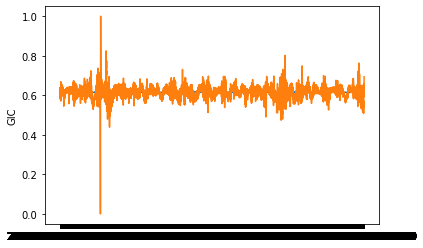


Linear Regression Model
Cross Validation Scores:  [ 0.00299607  0.00108466  0.00565664  0.0014339  -0.0005125   0.00318766
 -0.00121552  0.00535292  0.00294822  0.00577929]
Mean Squared Error:  0.0008163691073878881
accuracy:  0.004030389118369171


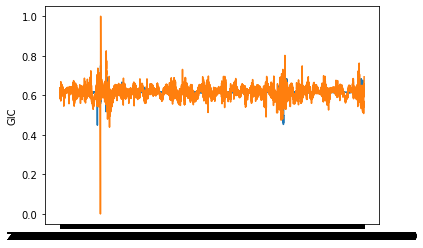


Random Forest Regressor
Cross Validation Scores:  [0.05914178 0.02943277 0.02012938 0.06891526 0.00508662 0.00566414
 0.01955871 0.04948399 0.07660081 0.04984292]
Mean Squared Error:  0.0008436808806137218
accuracy:  -0.029289950794121555


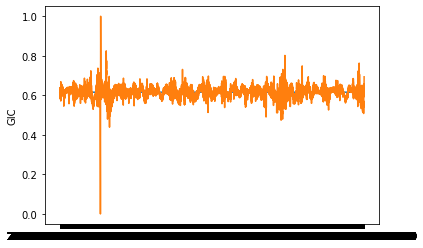


Lasso Regression Model
Cross Validation Scores:  [-2.83943928e-04 -7.32123617e-06 -3.58052245e-05 -2.65346290e-05
 -3.65552134e-06 -5.44674951e-04 -6.62081380e-05 -4.36770466e-04
 -3.97321847e-06 -1.10977010e-06]
Mean Squared Error:  0.0008206940753946731
accuracy:  -0.0012460681407446828

Gradient Boosting Regressor
Cross Validation Scores:  [0.05871107 0.03458995 0.01944939 0.06547041 0.00480476 0.02788982
 0.01802351 0.04085026 0.07071296 0.03959308]
Mean Squared Error:  0.0008540812095325944
accuracy:  -0.04197834315565263


In [141]:
from types import FunctionType

methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
methods.remove('__init__')
# Now calling the all regression methods
cross_scores_list, mse_list, accuracy_list = [], [], []
for model in methods:
    reg = Models(x_train, x_validation, y_train, y_validation)
    cross_val_scores, mse, accuracy= getattr(reg, model)(x_train, x_validation, y_train, y_validation)
    cross_scores_list.append(cross_val_scores)
    mse_list.append(mse)
    accuracy_list
    accuracy_list.append(accuracy)

In [142]:
plot_df = pd.DataFrame()
for i in range(len(methods)):
    plot_df[methods[i]] = cross_scores_list[i]

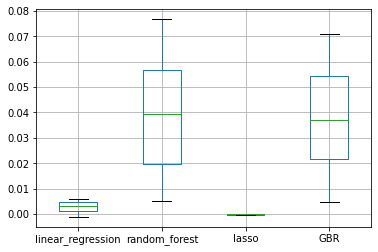

In [143]:
boxplot = plot_df.boxplot(column=['linear_regression','random_forest','lasso','GBR'])

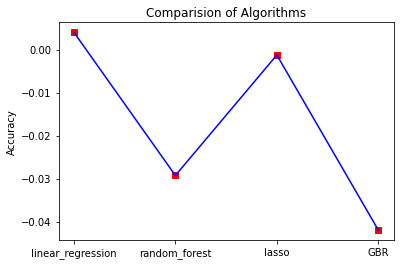

In [144]:
# Plot Mean Squared Error

plt.plot(accuracy_list, c='b')
plt.title('Comparision of Algorithms')
plt.ylabel('Accuracy')
#plt.ylim(0.0008, 0.015)
x = np.array([0,1,2,3])
plt.scatter(x, accuracy_list, c='r', marker="s")
plt.xticks(x, methods)
plt.show()

In [139]:
# Importing sklearn methods
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## --------------- Scaled

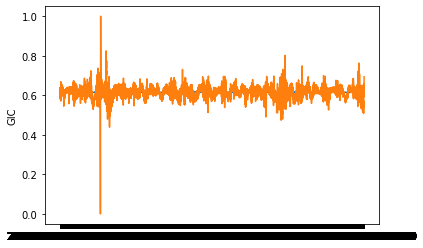


Linear Regression Model
Cross Validation Scores:  [ 0.00299607  0.00108466  0.00565664  0.0014339  -0.0005125   0.00318766
 -0.00121552  0.00535292  0.00294822  0.00577929]
Mean Squared Error:  0.0008163691073878881
accuracy:  0.004030389118369171


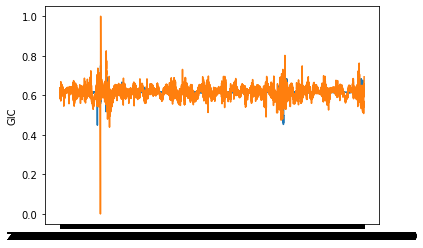


Random Forest Regressor
Cross Validation Scores:  [0.05914178 0.02943277 0.02012938 0.06891526 0.00508662 0.00566414
 0.01955871 0.04948399 0.07660081 0.04984292]
Mean Squared Error:  0.0008436808806137218
accuracy:  -0.029289950794121555


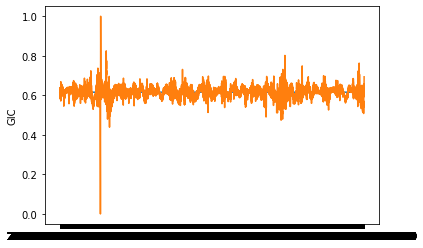


Lasso Regression Model
Cross Validation Scores:  [-2.83943928e-04 -7.32123617e-06 -3.58052245e-05 -2.65346290e-05
 -3.65552134e-06 -5.44674951e-04 -6.62081380e-05 -4.36770466e-04
 -3.97321847e-06 -1.10977010e-06]
Mean Squared Error:  0.0008206940753946731
accuracy:  -0.0012460681407446828

Gradient Boosting Regressor
Cross Validation Scores:  [0.05871107 0.03458995 0.01944939 0.06547041 0.00480476 0.02788982
 0.01802351 0.04085026 0.07071296 0.03959308]
Mean Squared Error:  0.0008540812095325944
accuracy:  -0.04197834315565263


In [181]:
from types import FunctionType

methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
methods.remove('__init__')
# Now calling the all regression methods
cross_scores_list, mse_list, accuracy_list = [], [], []
for model in methods:
    reg = Models(x_train, x_validation, y_train, y_validation)
    cross_val_scores, mse, accuracy= getattr(reg, model)(x_train, x_validation, y_train, y_validation)
    cross_scores_list.append(cross_val_scores)
    mse_list.append(mse)
    accuracy_list
    accuracy_list.append(accuracy)

In [70]:
# We use GridSearchCV to find out the best set of parameters for GBR and use it for the 
# regression model analysis and prediction
parameters = {
    'n_estimators' : [170, 175, 180],
    'learning_rate' : [0.075, 0.08, 0.1],
    'max_depth' : [2, 3, 4]
}

gbr = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, max_depth=5, random_state=232, loss='ls')
gs_cv = GridSearchCV(gbr, parameters).fit(x_train, y_train)
gs_cv.best_params_

{'learning_rate': 0.075, 'max_depth': 2, 'n_estimators': 170}

# ------ With -99999.990000

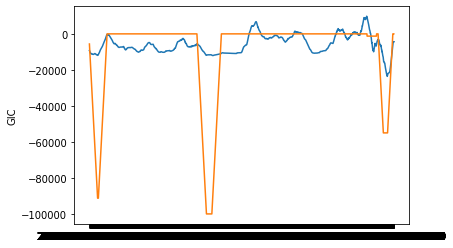


Linear Regression Model
Cross Validation Scores:  [0.0995631  0.10406999 0.10143329 0.09775554 0.10477924 0.10958142
 0.10507188 0.10154454 0.10412934 0.09822321]
Mean Squared Error:  485057273.5422226
accuracy:  0.12448416079895153


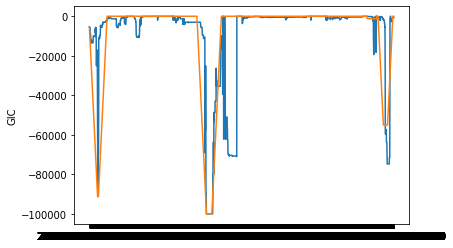


Random Forest Regressor
Cross Validation Scores:  [0.58967976 0.63298466 0.60166323 0.56061098 0.58932491 0.59640633
 0.59804409 0.5950115  0.61079019 0.58548938]
Mean Squared Error:  393513780.44311607
accuracy:  0.28971779929026875


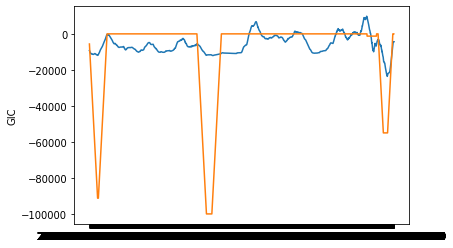


Lasso Regression Model
Cross Validation Scores:  [0.0995631  0.10406999 0.10143329 0.09775554 0.10477924 0.10958142
 0.10507188 0.10154454 0.10412934 0.09822321]
Mean Squared Error:  485057280.0856541
accuracy:  0.1244841489882269

Gradient Boosting Regressor
Cross Validation Scores:  [0.55361669 0.60105297 0.57757003 0.5328688  0.55957665 0.56242967
 0.56109451 0.55871382 0.57413044 0.54817715]
Mean Squared Error:  321216483.5948772
accuracy:  0.42021255109516753


In [71]:
from types import FunctionType

methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
methods.remove('__init__')
# Now calling the all regression methods
cross_scores_list, mse_list, accuracy_list = [], [], []
for model in methods:
    reg = Models(x_train, x_validation, y_train, y_validation)
    cross_val_scores, mse, accuracy= getattr(reg, model)(x_train, x_validation, y_train, y_validation)
    cross_scores_list.append(cross_val_scores)
    mse_list.append(mse)
    accuracy_list
    accuracy_list.append(accuracy)

In [72]:
plot_df = pd.DataFrame()
for i in range(len(methods)):
    plot_df[methods[i]] = cross_scores_list[i]

In [73]:
plot_df

,linear_regression,random_forest,lasso,GBR
0,0.099563,0.589680,0.099563,0.553617
1,0.104070,0.632985,0.104070,0.601053
2,0.101433,0.601663,0.101433,0.577570
3,0.097756,0.560611,0.097756,0.532869
4,0.104779,0.589325,0.104779,0.559577
5,0.109581,0.596406,0.109581,0.562430
6,0.105072,0.598044,0.105072,0.561095
7,0.101545,0.595011,0.101545,0.558714
8,0.104129,0.610790,0.104129,0.574130
9,0.098223,0.585489,0.098223,0.548177


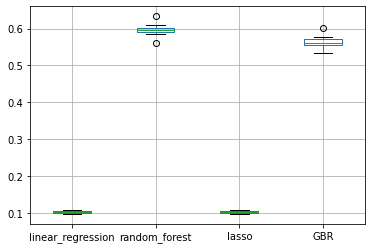

In [74]:
boxplot = plot_df.boxplot(column=['linear_regression','random_forest','lasso','GBR'])

In [61]:
import seaborn as sns

In [1]:
#plt.figure(figsize=(10,6))
plt.title('Comparison of Algorithms')
sns.boxplot(plot_df)
#plt.ylim(0.7, 1.0)
plt.ylabel('Cross Val Score')
plt.show()

NameError: name 'plt' is not defined

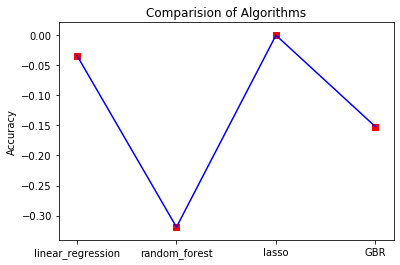

In [63]:
# Plot Mean Squared Error

plt.plot(accuracy_list, c='b')
plt.title('Comparision of Algorithms')
plt.ylabel('Accuracy')
#plt.ylim(0.0008, 0.015)
x = np.array([0,1,2,3])
plt.scatter(x, accuracy_list, c='r', marker="s")
plt.xticks(x, methods)
plt.show()

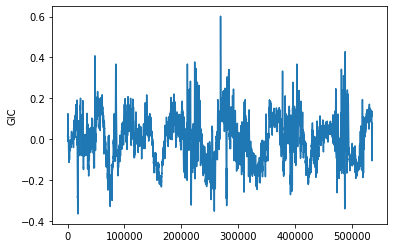

In [67]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.ylabel('GIC')
plt.show()

In [74]:
methods[1]

'random_forest'

In [ ]:
.predict(diabetes_X_test)

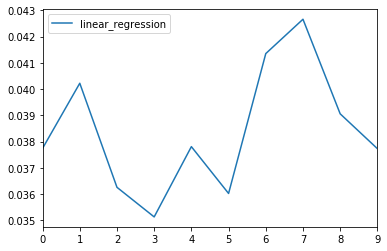

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# a simple line plot
plot_df.plot(kind='line',y='linear_regression')

In [64]:
y

159       0.012438
160       0.013000
161       0.013625
162       0.014125
163       0.014813
            ...   
534952    0.079312
534953    0.079250
534954    0.079312
534955    0.079250
534956    0.079125
Name: gic, Length: 534798, dtype: float64

In [ ]:
# Plot Mean Squared Error

plt.plot(accuracy_list, c='b')
plt.title('Comparision of Algorithms')
plt.ylabel('Accuracy')
#plt.ylim(0.0008, 0.015)
x = np.array([0,1,2,3])
plt.scatter(x, accuracy_list, c='r', marker="s")
plt.xticks(x, methods)
plt.show()

In [100]:
reg.score(x_validation, y_validation)

reg.coef_

reg.intercept_

reg.predict(np.array([[3, 5, 3]]))


AttributeError: 'Models' object has no attribute 'score'

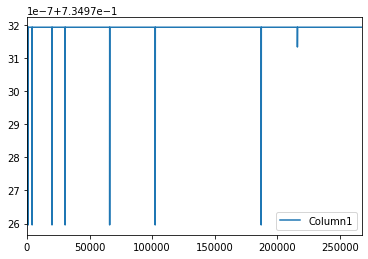

In [87]:
#dfxx = pred_test_y
dataset.plot()

In [79]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_test, (pred_test_y > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1))
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

ValueError: Classification metrics can't handle a mix of continuous and binary targets